This notebook is a tutorial for ATAC analysis using SEACells and includes computation of gene-peak associations, ATAC gene scores, gene accessibility scores and identification of highly regulated genes

# Imports

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc

In [2]:
import SEACells

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


In [3]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Some plotting aesthetics
%matplotlib inline

sns.set_style('ticks')
matplotlib.rcParams['figure.figsize'] = [4, 4]
matplotlib.rcParams['figure.dpi'] = 100


# Load Data

We recommend the use of scanpy Anndata objects as the preferred mode of loading and filtering data.

A sample datset is available for download with the instructions listed below. This is a filtered, unnormalized counts of multiome dataset of CD34+ sorted bone marrow cells to profile human hematopoiesis [Dataset ref TBD]. 

Uncomment the following lines to download the sample dataset in a Unix-based system. For non-UNIX systems, download the files using the URL

In [5]:
# !mkdir data/
# !wget https://dp-lab-data-public.s3.amazonaws.com/SEACells-multiome/cd34_multiome_rna.h5ad -O data/cd34_multiome_rna.h5ad # RNA data
# !wget https://dp-lab-data-public.s3.amazonaws.com/SEACells-multiome/cd34_multiome_atac.h5ad -O data/cd34_multiome_atac.h5ad # ATAC data

The dataset contains RNA and ATAC modalities as two different Anndata objects. The ATAC dataset contains precomputed SEACell metacells 

In [6]:
import os
os.listdir('data/')

['cd34_multiome_gene_peak_cors.p',
 'cd34_multiome_rna.h5ad',
 'cd34_multiome_atac.h5ad',
 'hg38.gtf']

In [7]:
# Load the data using scanpy
rna_ad = sc.read('data/cd34_multiome_rna.h5ad')
atac_ad = sc.read('data/cd34_multiome_atac.h5ad')

In [8]:
rna_ad

AnnData object with n_obs × n_vars = 6881 × 12464
    obs: 'leiden', 'celltype'
    var: 'highly_variable'
    uns: 'celltype_colors'
    obsm: 'X_umap'

In [9]:
atac_ad

AnnData object with n_obs × n_vars = 6881 × 246113
    obs: 'Sample', 'TSSEnrichment', 'ReadsInTSS', 'ReadsInPromoter', 'ReadsInBlacklist', 'PromoterRatio', 'PassQC', 'NucleosomeRatio', 'nMultiFrags', 'nMonoFrags', 'nFrags', 'nDiFrags', 'BlacklistRatio', 'Clusters', 'ReadsInPeaks', 'FRIP', 'leiden', 'phenograph', 'celltype', 'SEACell'
    var: 'seqnames', 'start', 'end', 'width', 'strand', 'score', 'replicateScoreQuantile', 'groupScoreQuantile', 'Reproducibility', 'GroupReplicate', 'nearestGene', 'distToGeneStart', 'peakType', 'distToTSS', 'nearestTSS', 'GC', 'idx'
    uns: 'celltype_colors'
    obsm: 'X_umap'

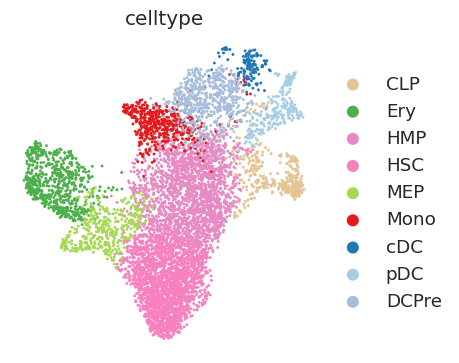

In [10]:
# Plot cell-types for reference (RNA)
sc.pl.scatter(rna_ad, basis='umap', color='celltype', frameon=False)

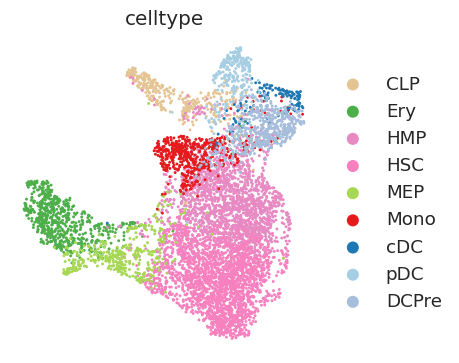

In [11]:
# Plot cell-types for reference (ATAC)
sc.pl.scatter(atac_ad, basis='umap', color='celltype', frameon=False)

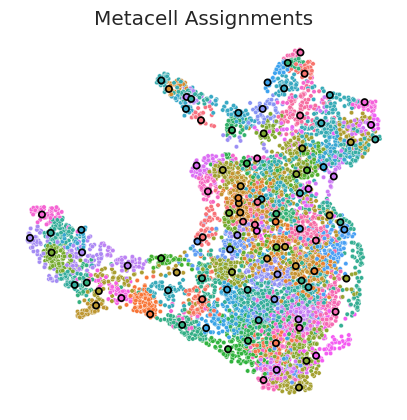

In [12]:
SEACells.plot.plot_2D(atac_ad, key='X_umap', colour_metacells=True)

# Preparation step


In the first step, we derive summarized ATAC and RNA SEACell metacells Anndata objects. Both the input single-cell RNA and ATAC anndata objects should contain raw, unnormalized data. SEACell results on ATAC data will be used for the summarization

<b>Warning: </b> The ATAC and RNA single-cell Anndata objects should contain the same set of cells. Only the common cells will be used for downstream analyses.

In [13]:
import SEACells

In [14]:
atac_meta_ad, rna_meta_ad = SEACells.genescores.prepare_multiome_anndata(atac_ad, rna_ad, SEACell_label='SEACell')

Generating Metacell matrices...
 ATAC


100%|███████████████████████████████████████████████████████████████████████████████████| 99/99 [00:05<00:00, 17.61it/s]
Trying to set attribute `.obs` of view, copying.


 RNA


/home/msetty/.conda/envs/squidpy/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:00<00:00, 484.92it/s]


The preparation step will generate summarized anndata objects for RNA and ATAC

In [15]:
atac_meta_ad

AnnData object with n_obs × n_vars = 99 × 246113
    obs: 'n_counts'
    var: 'GC_bin', 'counts_bin'

In [16]:
rna_meta_ad

AnnData object with n_obs × n_vars = 99 × 12464

# Gene-peak correlations

Using the paired multiome metacell data, the next step is to compute the correlation of gene expression and accessbility of peaks within the vicinity of the gene. 

Computation of gene peak correlations requires the following parameters :
1. GTF file with gene annotations. <b> Note: </b> Chromosome names should be numbered 1, 2 and the "chr" prefix will be added by SEACells 
2. Genomic span around genes to test the correlations 

Human GTF file is available at [https://dp-lab-data-public.s3.amazonaws.com/SEACells-multiome/hg38.gtf](https://dp-lab-data-public.s3.amazonaws.com/SEACells-multiome/hg38.gtf) and can be downloaded using:

In [17]:
#! wget https://dp-lab-data-public.s3.amazonaws.com/SEACells-multiome/hg38.gtf -O data/hg38.gtf

In [18]:
# In this example, we compute gene peak correlations for the first ten genes since 
# this process is computationally intensive
gene_set = rna_meta_ad.var_names[:10]
gene_peak_cors = SEACells.genescores.get_gene_peak_correlations(atac_meta_ad, rna_meta_ad, 
                                           path_to_gtf='data/hg38.gtf', 
                                           span=100000, 
                                           n_jobs=1,
                                           gene_set=gene_set)

Loading transcripts per gene...
Preparing matrices for gene-peak associations


  0%|                                                                                            | 0/10 [00:00<?, ?it/s]

Computing peak-gene correlations


 30%|█████████████████████████▏                                                          | 3/10 [00:01<00:04,  1.73it/s]/home/msetty/.conda/envs/squidpy/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:1919: RuntimeWarning: invalid value encountered in double_scalars
  x = np.asarray((x - loc)/scale, dtype=dtyp)
 40%|█████████████████████████████████▌                                                  | 4/10 [00:02<00:04,  1.32it/s]/home/msetty/.conda/envs/squidpy/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:1919: RuntimeWarning: invalid value encountered in double_scalars
  x = np.asarray((x - loc)/scale, dtype=dtyp)
100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:09<00:00,  1.10it/s]


The result of this function is a `pandas.Series` object with one entry for each gene. Each entry is a `pandas.DataFrame` with the correlation of peak accessibility and gene expression and the p-value for significance of correlation using GC and accessiblity matched background sets

In [19]:
gene_peak_cors.index

Index(['LINC01128', 'FAM41C', 'NOC2L', 'ISG15', 'AGRN', 'C1orf159', 'SDF4',
       'B3GALT6', 'UBE2J2', 'SCNN1D'],
      dtype='object')

In [20]:
gene_peak_cors['FAM41C'].head()

,cor,pval
chr1:816070-816570,0.045967,0.620261
chr1:817092-817592,0.137940,0.456148
chr1:827266-827766,-0.029674,0.804841
chr1:838271-838771,-0.032071,0.846549
chr1:842638-843138,-0.162115,0.948897


If no peaks are present in the specified span of the gene, the entry in the dictionary contains a zero

In [21]:
gene_peak_cors['LINC01128']

0

## Highly regulated genes

For downstream analyses, the full gene peak correlations results are available as a pickle file at [https://dp-lab-data-public.s3.amazonaws.com/SEACells-multiome/cd34_multiome_gene_peak_cors.p](https://dp-lab-data-public.s3.amazonaws.com/SEACells-multiome/cd34_multiome_gene_peak_cors.p) and can be downloaded using


In [22]:
#! wget https://dp-lab-data-public.s3.amazonaws.com/SEACells-multiome/cd34_multiome_gene_peak_cors.p -O data/cd34_multiome_gene_peak_cors.p

In [23]:
gene_peak_cors = pd.read_pickle('data/cd34_multiome_gene_peak_cors.p') 

In [24]:
len(gene_peak_cors)

12464

Highly regulated genes i.e., genes that are correlated with multiple peaks can be identified using the `get_gene_peak_assocations` function. `get_gene_peak_assocations` returns the number of significantly peaks correlated with each gene

In [25]:
peak_counts = SEACells.genescores.get_gene_peak_assocations(gene_peak_cors, 
                                                           pval_cutoff=1e-1,
                                                           cor_cutoff=0.1)

100%|███████████████████████████████████████████████████████████████████████████| 12464/12464 [00:05<00:00, 2264.55it/s]


In [26]:
peak_counts

LINC01128    0
FAM41C       4
NOC2L        4
ISG15        6
AGRN         5
            ..
BRCC3        1
VBP1         2
RAB39B       6
CLIC2        1
TMLHE        3
Length: 12464, dtype: int64

Text(0, 0.5, 'No. of correlated peaks')

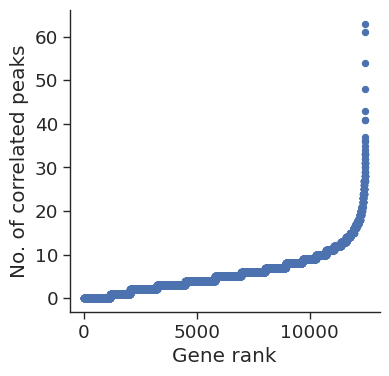

In [27]:
# Plot the distribution to identify genes with higher degree of regulation
plt.scatter(np.arange(len(peak_counts)), 
           np.sort(peak_counts), s=20)
sns.despine()
plt.xlabel('Gene rank')
plt.ylabel('No. of correlated peaks')

## Gene scores

Gene scores are computed as the weighted sum of the accessiblity of correlated peaks and can be computed using `get_gene_scores`. 

In [28]:
gene_scores = SEACells.genescores.get_gene_scores(atac_meta_ad, 
                                                  gene_peak_cors,
                                                  pval_cutoff=1e-1,
                                                  cor_cutoff=0.1)

100%|█████████████████████████████████████████████████████████████████████████████| 12464/12464 [04:01<00:00, 51.57it/s]


In [29]:
gene_scores.head()

,LINC01128,FAM41C,NOC2L,ISG15,AGRN,C1orf159,SDF4,B3GALT6,UBE2J2,SCNN1D,...,MPP1,F8,FUNDC2,CMC4,MTCP1,BRCC3,VBP1,RAB39B,CLIC2,TMLHE
cd34_multiome_rep1#TTGCAGCCAGGCGATA-1,0.0,0.005829,0.009785,0.018159,0.053374,0.042345,0.036484,0.014096,0.029941,0.003039,...,0.006971,0.002203,0.000000,0.001719,0.015165,0.004225,0.00000,0.035308,0.034425,0.005338
cd34_multiome_rep1#TACAGCTAGTAATCCA-1,0.0,0.017462,0.007034,0.021173,0.026875,0.018844,0.034083,0.020050,0.033753,0.012982,...,0.024762,0.007021,0.000000,0.001290,0.002502,0.007835,0.00000,0.051158,0.050683,0.004603
cd34_multiome_rep2#TAACCTAAGGATTGAG-1,0.0,0.026632,0.008566,0.027379,0.026118,0.020141,0.030814,0.012761,0.033828,0.013474,...,0.012807,0.000000,0.000000,0.000000,0.011502,0.001524,0.00000,0.045826,0.043820,0.003887
cd34_multiome_rep1#TAGCGGCTCATTATGG-1,0.0,0.003788,0.024816,0.008464,0.016567,0.020965,0.078593,0.065220,0.093520,0.049712,...,0.124604,0.036083,0.003839,0.016096,0.007937,0.003655,0.03626,0.057396,0.059264,0.007541
cd34_multiome_rep1#GCCCATAAGATGCCTG-1,0.0,0.021467,0.005354,0.019011,0.016332,0.017859,0.024918,0.019455,0.024968,0.008479,...,0.017892,0.004407,0.000000,0.002284,0.010087,0.003307,0.00000,0.055975,0.082281,0.006632


In [30]:
gene_scores.shape

(99, 12464)

`gene_scores` is a `pandas.DataFrame` with metacells as rows and genes as columns. This can be used for any downstream analysis such as clustering, visualization etc.